In [8]:
from random import seed
import numpy as np
import pandas as pd
import torch
import pickle as pkl
from conorm import cpm
seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [9]:
test = pd.read_csv('data/test_set.csv')

In [10]:
cell_lines = ['HCC1937', 'HCC1187',
              'HCC70', 'BT549', 'MDAMB436', 'BT20',
              'HDQP1', 'HCC1143', 'SUM185', 'SUM229', 'SUM147',
              'SUM150', 'SUM1315']
afatinib = pd.read_csv('data/afatinib.csv')
afatinib['cl'] = [t.replace('-','') for t in afatinib['Cell line']]
afatinib = afatinib.loc[ [ t in cell_lines for t in afatinib['cl'] ],: ]

In [11]:
model = pkl.load(open('models/scASTRAL_pipeline.sk','rb'))

In [12]:
test_data = {
    cl : {  'data': test.loc[test['cell_line']==cl,[t for t in test.columns if 'ENSG' in t]] ,
            'ic50': afatinib.loc[afatinib['cl']==cl,'IC50'].iloc[0] }
    for cl in afatinib['cl']}

In [13]:
report = {}
for cl in test_data.keys():
    if test_data[cl]['data'].shape[0]>0:

        pred = model.predict(test_data[cl]['data'])

        report[cl]= {
            '%pred':  np.nanmean(pred),
            'logIC50': np.log2(test_data[cl]['ic50'])}

r = pd.DataFrame.from_dict(report).T


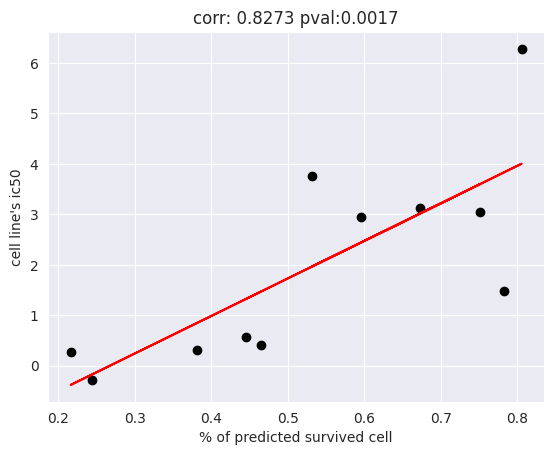

In [14]:
res = spearmanr(r['logIC50'],r['%pred'])
x = np.array(r['%pred'])
y = np.array(r['logIC50'])
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y, c='black')
plt.plot(x, a * x + b, c='red')
plt.xlabel('% of predicted survived cell')
plt.ylabel('cell line\'s ic50')
plt.title(f'corr: {res.correlation:.4f} pval:{res.pvalue:.4f}')
plt.show()